In [1]:
library(ArchR)
set.seed(1)
addArchRThreads(threads = 1)
addArchRGenome("hg38")


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .______      
          /   \     |   _ 

# 1. Preprocessing

## 1.1 Create arrow files

In [ ]:
inputFiles <- c(CD33pos = '../../Datasets/A00497/count/CD33pos_SRao10xscATACLIB_SI-NA-D1/outs/fragments.tsv.gz',
                CD34posCD33='../../Datasets/A00497/count/CD34posCD33_SRao10xscATACLIB_SI-NA-B1/outs/fragments.tsv.gz',
                CD34posCD33L='../../Datasets/A00497/count/CD34posCD33L_SRao10xscATACLIB_SI-NA-C1/outs/fragments.tsv.gz',
                D0='../../Datasets/A00497/count/D0_SRao10xscATACLIB_SI-NA-E1/outs/fragments.tsv.gz',
                D12='../../Datasets/A00497/count/D12_SRao10xscATACLIB_SI-NA-H1/outs/fragments.tsv.gz',
                D4='../../Datasets/A00497/count/D4_SRao10xscATACLIB_SI-NA-F1/outs/fragments.tsv.gz',
                D7='../../Datasets/A00497/count/D7_SRao10xscATACLIB_SI-NA-G1/outs/fragments.tsv.gz')
inputFiles

In [ ]:
ArrowFiles <- createArrowFiles(
  inputFiles = inputFiles,
  sampleNames = names(inputFiles),
  filterTSS = 4, #Dont set this too high because you can always increase later
  filterFrags = 1000, 
  addTileMat = TRUE,
  addGeneScoreMat = TRUE
)

## 1.1 Read in data

In [11]:
proj <- ArchRProject(
  ArrowFiles = c('../data/hematopoiesis/result_1b-ATAC_by_ArchR/ArrowFiles/CD34posCD33.arrow',
                 '../data/hematopoiesis/result_1b-ATAC_by_ArchR/ArrowFiles/D7.arrow',
                 '../data/hematopoiesis/result_1b-ATAC_by_ArchR/ArrowFiles/D0.arrow',
                 '../data/hematopoiesis/result_1b-ATAC_by_ArchR/ArrowFiles/D12.arrow',
                 '../data/hematopoiesis/result_1b-ATAC_by_ArchR/ArrowFiles/D4.arrow',
                 '../data/hematopoiesis/result_1b-ATAC_by_ArchR/ArrowFiles/CD34posCD33L.arrow',
                 '../data/hematopoiesis/result_1b-ATAC_by_ArchR/ArrowFiles/CD33pos.arrow'), 
  outputDirectory = "../data/hematopoiesis/result_1b-ATAC_by_ArchR/",
  copyArrows = TRUE #This is recommened so that you maintain an unaltered copy for later usage.
)
proj

Using GeneAnnotation set by addArchRGenome(Hg38)!

Using GeneAnnotation set by addArchRGenome(Hg38)!

Validating Arrows...



ERROR: Error in H5Fopen(file, flags = flags, fapl = fapl, native = native): HDF5. File accessibility. Unable to open file.


## 1.2 QC

In [4]:
filterDoublets <- function(ArchRProj = NULL, cutEnrich = 1, cutScore = -Inf, filterRatio = 1){

  fn <- unclass(lsf.str(envir = asNamespace("ArchR"), all = TRUE))
    for (i in seq_along(fn)) {
        tryCatch({
            eval(parse(text = paste0(fn[i], "<-ArchR:::", fn[i])))
        }, error = function(x) {
        })
    }

  .validInput(input = ArchRProj, name = "ArchRProj", valid = c("ArchRProj"))
  .validInput(input = cutEnrich, name = "cutEnrich", valid = c("numeric"))
  .validInput(input = cutScore, name = "cutScore", valid = c("numeric"))
  .validInput(input = filterRatio, name = "filterRatio", valid = c("numeric"))

  if(any(grepl("filterDoublets", names(ArchRProj@projectSummary)))){
    stop("Already ran filterDoublets on ArchRProject! Cannot be re-ran on an ArchRProject!")
  }

  df <- getCellColData(ArchRProj, c("Sample", "DoubletEnrichment", "DoubletScore"))
  splitDF <- split(seq_len(nrow(df)), as.character(df$Sample))

  cellsFilter <- lapply(splitDF, function(y){

    x <- df[y, ,drop = FALSE]

    n <- nrow(x)

    x <- x[order(x$DoubletEnrichment, decreasing = TRUE), ]
    
    if(!is.null(cutEnrich)){
      x <- x[which(x$DoubletEnrichment >= cutEnrich), ]
    } 
    
    if(!is.null(cutScore)){
      x <- x[which(x$DoubletScore >= cutScore), ]
    } 

    if(nrow(x) > 0){
      head(rownames(x), filterRatio * n * (n / 100000))
    }else{
      NULL
    }

  }) %>% unlist(use.names=FALSE)

  message("Filtering ", length(cellsFilter), " cells from ArchRProject!")
  tabRemove <- table(df[cellsFilter,]$Sample)
  tabAll <- table(df$Sample)
  samples <- unique(df$Sample)
  for(i in seq_along(samples)){
    if(!is.na(tabRemove[samples[i]])){
      message("\t", samples[i], " : ", tabRemove[samples[i]], " of ", tabAll[samples[i]], " (", round(100 * tabRemove[samples[i]] / tabAll[samples[i]], 1),"%)")
    }else{
      message("\t", samples[i], " : ", 0, " of ", tabAll[samples[i]], " (0%)")
    }
  }

  if(length(cellsFilter) > 0){
    
    ArchRProj@cellColData <- ArchRProj@cellColData[rownames(ArchRProj@cellColData) %ni% cellsFilter,,drop=FALSE]

  }
  
  ArchRProj

}


In [5]:
proj <- filterDoublets(ArchRProj = proj,cutEnrich=5)
proj <- addIterativeLSI(ArchRProj = proj, useMatrix = "TileMatrix", name = "IterativeLSI")
proj

Filtering 549 cells from ArchRProject!

	CD34posCD33 : 166 of 4082 (4.1%)

	D7 : 0 of 5026 (0%)

	D0 : 0 of 5320 (0%)

	D12 : 98 of 4388 (2.2%)

	D4 : 230 of 4800 (4.8%)

	CD34posCD33L : 0 of 4671 (0%)

	CD33pos : 55 of 5043 (1.1%)

Checking Inputs...

ArchR logging to : ArchRLogs/ArchR-addIterativeLSI-38e9f305167-Date-2023-01-24_Time-18-19-38.log
If there is an issue, please report to github with logFile!

2023-01-24 18:19:42 : Computing Total Across All Features, 0.022 mins elapsed.

2023-01-24 18:20:00 : Computing Top Features, 0.328 mins elapsed.

###########
2023-01-24 18:20:01 : Running LSI (1 of 2) on Top Features, 0.346 mins elapsed.
###########

2023-01-24 18:20:02 : Sampling Cells (N = 10003) for Estimated LSI, 0.348 mins elapsed.

2023-01-24 18:20:02 : Creating Sampled Partial Matrix, 0.348 mins elapsed.

2023-01-24 18:20:37 : Computing Estimated LSI (projectAll = FALSE), 0.943 mins elapsed.

2023-01-24 18:21:58 : Identifying Clusters, 2.289 mins elapsed.

2023-01-24 18:22:2

class: ArchRProject 
outputDirectory: /mnt/c/Users/jobac/Desktop/all/STREAM2_Dan/DATA_INTEGRATION_SC/results/result_2.0-ATAC_only_Archr 
samples(7): CD34posCD33 D7 ... CD34posCD33L CD33pos
sampleColData names(1): ArrowFiles
cellColData names(15): Sample TSSEnrichment ... DoubletEnrichment
  BlacklistRatio
numberOfCells(1): 32781
medianTSS(1): 10.667
medianFrags(1): 24587

1 


Picking joint bandwidth of 0.465



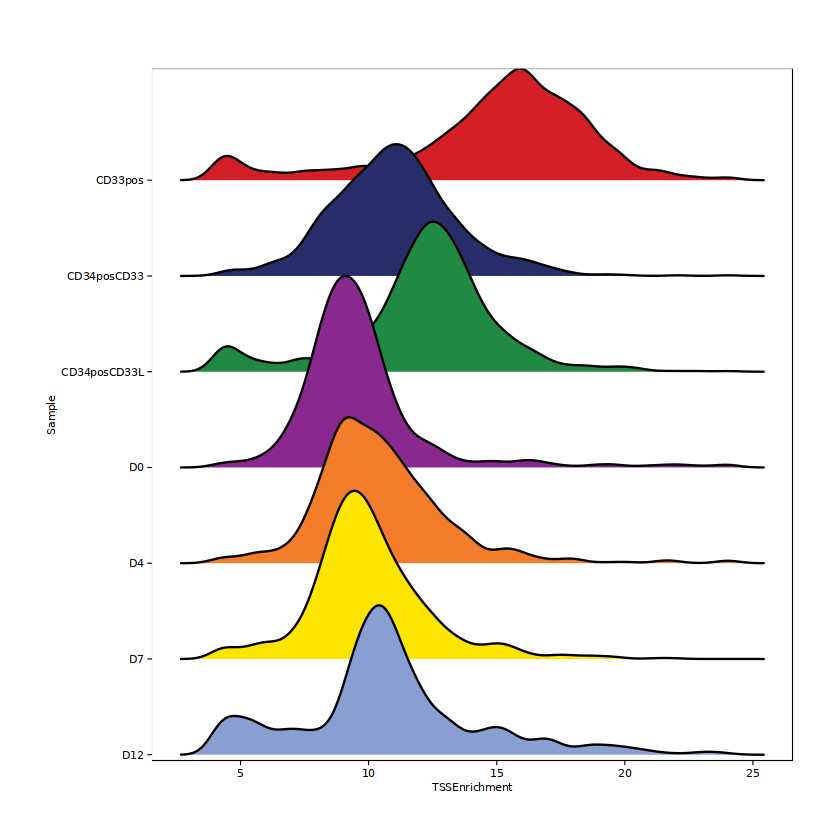

In [6]:
p0 <- plotGroups(
    ArchRProj = proj, 
    groupBy = "Sample", 
    colorBy = "cellColData", 
    name = "TSSEnrichment",
    plotAs = "ridges"
   )
p0

In [7]:
proj$Group = proj$Sample
proj$Group[startsWith(proj$Group,'CD')] = 'Refs'
proj$Group[startsWith(proj$Group,'D')] = 'Days'

proj <- saveArchRProject(ArchRProj = proj)

Saving ArchRProject...

Loading ArchRProject...

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
         

## group-wise

In [8]:
proj <- addHarmony(
    ArchRProj = proj,
    reducedDims = "IterativeLSI",
    name = "Harmony",
    groupBy = "Group",
    force = TRUE
)

proj <- addClusters(input = proj, reducedDims = "Harmony",force=TRUE,resolution = 0.5)

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony converged after 3 iterations

ArchR logging to : ArchRLogs/ArchR-addClusters-38e97a49d9db-Date-2023-01-24_Time-18-27-44.log
If there is an issue, please report to github with logFile!

2023-01-24 18:27:46 : Running Seurats FindClusters (Stuart et al. Cell 2019), 0.002 mins elapsed.

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 32781
Number of edges: 1240370

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9237
Number of communities: 41
Elapsed time: 7 seconds


20 singletons identified. 21 final clusters.

2023-01-24 18:28:36 : Testing Biased Clusters, 0.827 mins elapsed.

2023-01-24 18:28:36 : Testing Outlier Clusters, 0.829 mins elapsed.

2023-01-24 18:28:36 : Assigning Cluster Names to 21 Clusters, 0.829 mins elapsed.

2023-01-24 18:28:36 : Finished addClusters, 0.832 mins elapsed.



In [9]:
proj <- addUMAP(ArchRProj = proj, reducedDims = "Harmony",force=TRUE)

18:28:36 UMAP embedding parameters a = 0.7669 b = 1.223

18:28:36 Read 32781 rows and found 30 numeric columns

18:28:36 Using Annoy for neighbor search, n_neighbors = 40

18:28:36 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

18:28:42 Writing NN index file to temp file /tmp/RtmpXOju4N/file38e93a0e8a9f

18:28:43 Searching Annoy index using 6 threads, search_k = 4000

18:28:48 Annoy recall = 100%

18:28:49 Commencing smooth kNN distance calibration using 6 threads
 with target n_neighbors = 40

18:28:51 Initializing from normalized Laplacian + noise (using irlba)

18:28:56 Commencing optimization for 200 epochs, with 2006298 positive edges

18:29:17 Optimization finished

18:29:17 Creating temp model dir /tmp/RtmpXOju4N/dir38e913c733bd

18:29:17 Creating dir /tmp/Rtmp

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-38e913720b48-Date-2023-01-24_Time-18-30-10.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-38e913720b48-Date-2023-01-24_Time-18-30-10.log



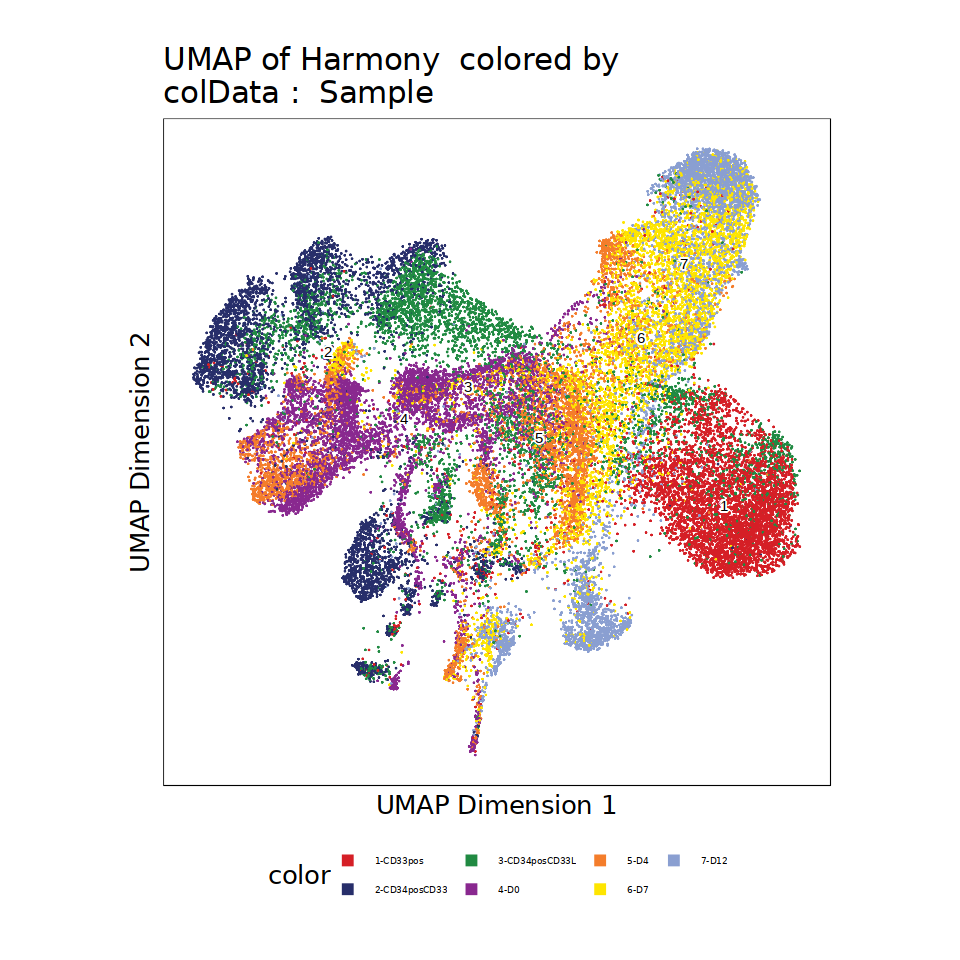

In [10]:
options(repr.plot.width=8, repr.plot.height=8)
p1 <- plotEmbedding(ArchRProj = proj, colorBy = "cellColData", name = "Sample", embedding = "UMAP",baseSize=15)
p1

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-38e92741dd88-Date-2023-01-24_Time-18-30-16.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-38e92741dd88-Date-2023-01-24_Time-18-30-16.log



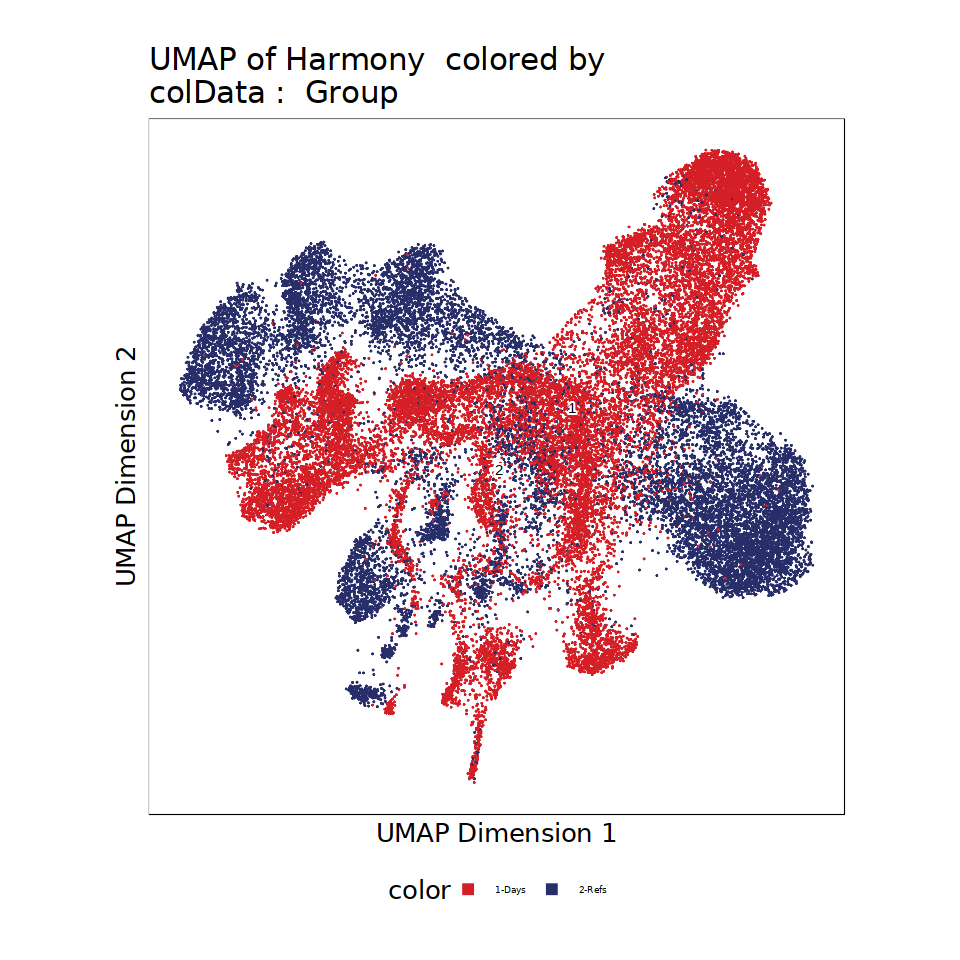

In [11]:
options(repr.plot.width=8, repr.plot.height=8)
p2 <- plotEmbedding(ArchRProj = proj, colorBy = "cellColData", name = "Group", embedding = "UMAP",baseSize=15)
p2

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-38e9178b2e30-Date-2023-01-24_Time-18-30-22.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 
Length of unique values greater than palette, interpolating..



ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-38e9178b2e30-Date-2023-01-24_Time-18-30-22.log



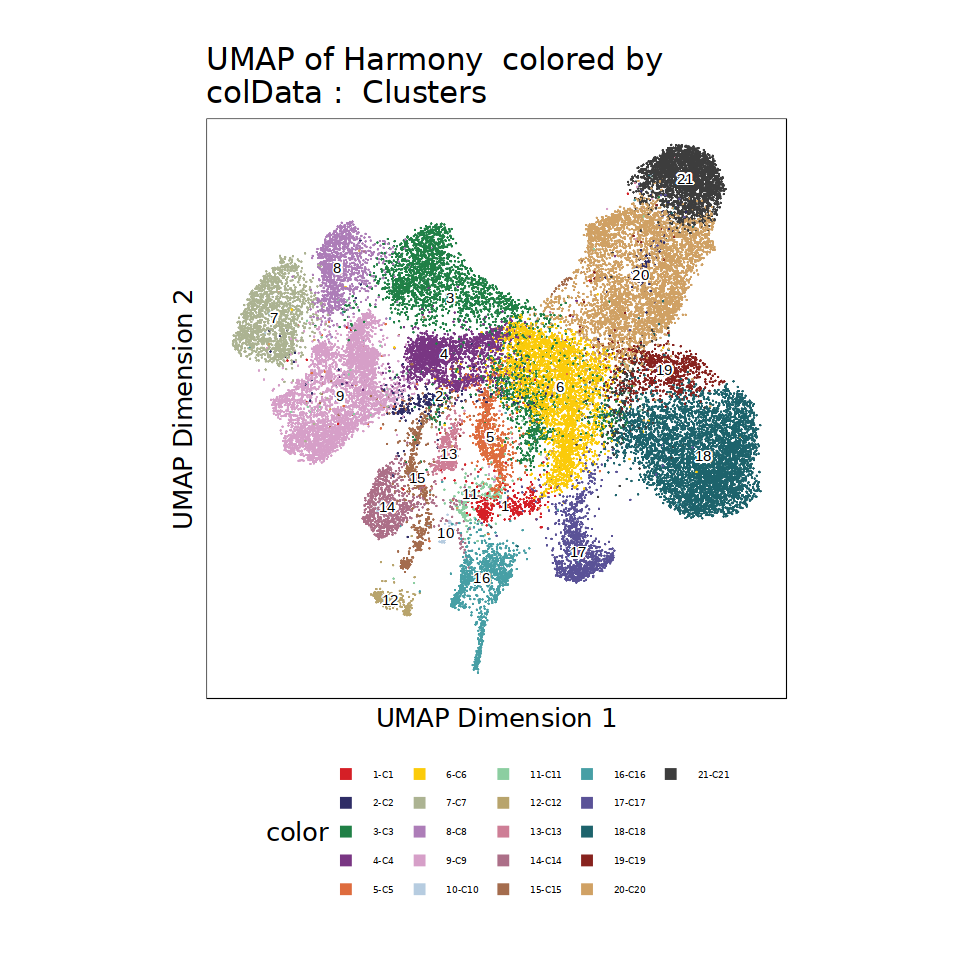

In [12]:
options(repr.plot.width=8, repr.plot.height=8)
p3 <- plotEmbedding(ArchRProj = proj, colorBy = "cellColData", name = "Clusters", embedding = "UMAP",baseSize=15)
p3

In [13]:
proj <- addImputeWeights(proj)

ArchR logging to : ArchRLogs/ArchR-addImputeWeights-38e9292925a2-Date-2023-01-24_Time-18-30-28.log
If there is an issue, please report to github with logFile!

2023-01-24 18:30:29 : Computing Impute Weights Using Magic (Cell 2018), 0 mins elapsed.



### marker genes visualization

Getting ImputeWeights

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-38e920586e29-Date-2023-01-24_Time-18-31-01.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = GeneScoreMatrix

Getting Matrix Values...

2023-01-24 18:31:04 : 



Imputing Matrix

Using weights on disk

Using weights on disk

Plotting Embedding

1 
2 
3 
4 
5 
6 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-38e920586e29-Date-2023-01-24_Time-18-31-01.log

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(

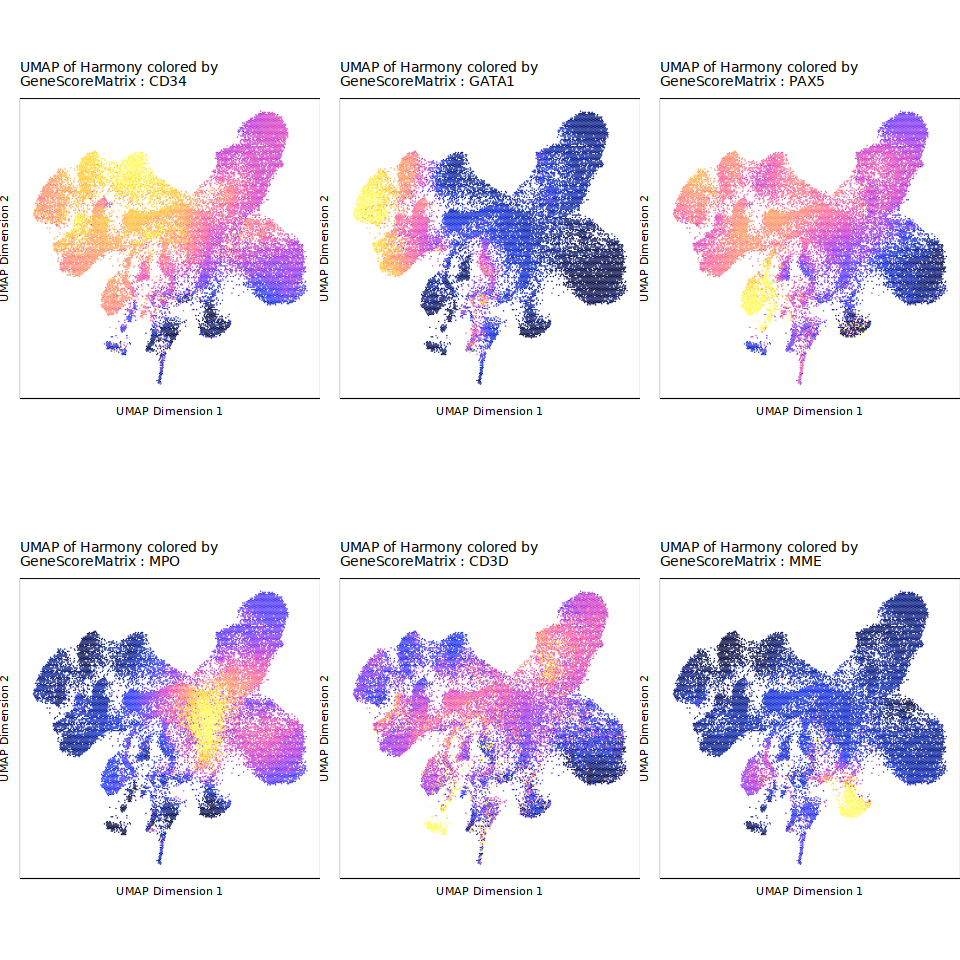

In [14]:
markerGenes  <- c(
    "CD34",  #Early Progenitor
    "GATA1", #Erythroid
    "PAX5", #B-Cell Trajectory
    "MPO", #Monocytes
    "CD3D", #TCells
    "MME" #neutrophil 
)

p <- plotEmbedding(
    ArchRProj = proj, 
    colorBy = "GeneScoreMatrix", 
    name = markerGenes, 
    embedding = "UMAP",
    imputeWeights = getImputeWeights(proj)
)

#Rearrange for grid plotting
p4 <- lapply(p, function(x){
    x + guides(color = FALSE, fill = FALSE) + 
    theme_ArchR(baseSize = 6.5) +
    theme(plot.margin = unit(c(0, 0, 0, 0), "cm")) +
    theme(
        axis.text.x=element_blank(), 
        axis.ticks.x=element_blank(), 
        axis.text.y=element_blank(), 
        axis.ticks.y=element_blank()
    )
})
do.call(cowplot::plot_grid, c(list(ncol = 3),p4))

### Get imputed gene score matrix

Getting ImputeWeights

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-38e977cc0b41-Date-2023-01-24_Time-20-33-19.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = GeneScoreMatrix

Getting Matrix Values...

2023-01-24 20:33:21 : 



Imputing Matrix

Using weights on disk

Using weights on disk

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-38e977cc0b41-Date-2023-01-24_Time-20-33-19.log



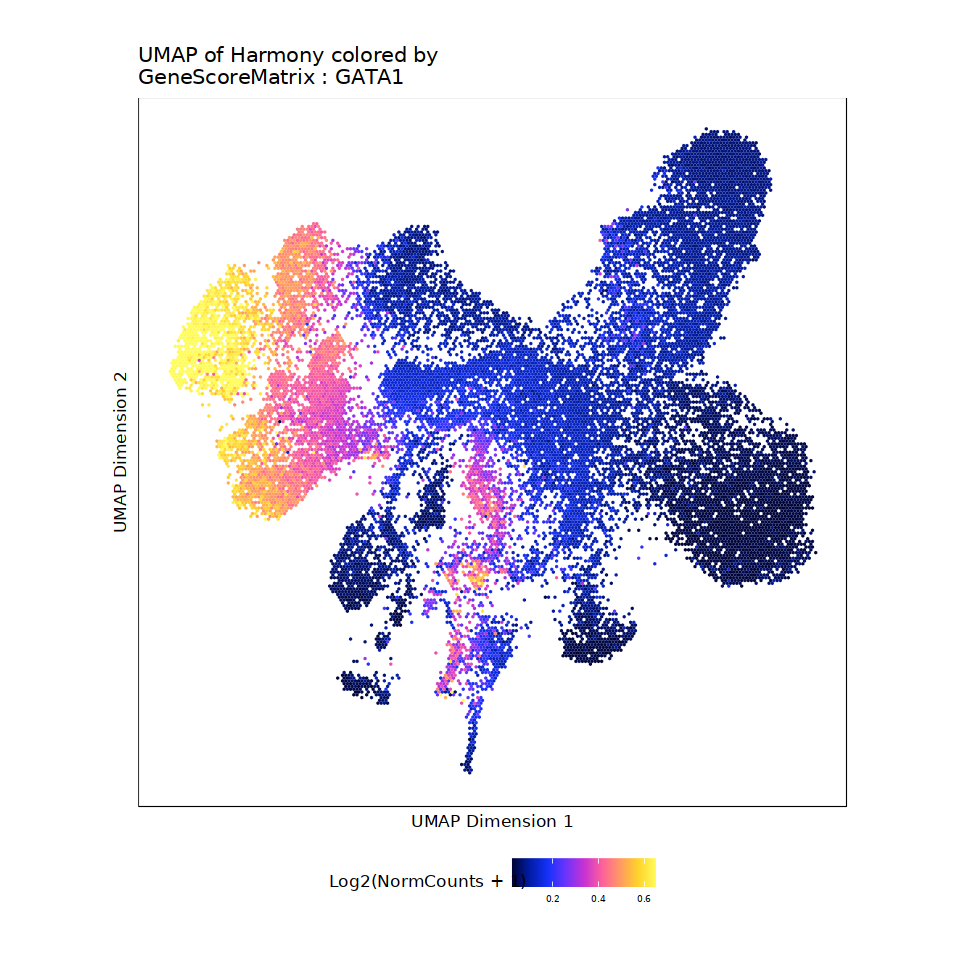

In [16]:
### original GATA1 expression
p0 = plotEmbedding(ArchRProj = proj, colorBy = "GeneScoreMatrix", name = "GATA1", embedding = "UMAP",imputeWeights = getImputeWeights(proj))
p0

In [4]:
print("Getting ImputeWeights")
imputeWeights = getImputeWeights(proj2)

[1] "Getting ImputeWeights"


Getting ImputeWeights



In [4]:
data_gs <- getMatrixFromProject(
  ArchRProj = proj2,
  useMatrix = "GeneScoreMatrix",
  useSeqnames = NULL,
  verbose = TRUE,
  binarize = FALSE,
  threads = getArchRThreads(),
  logFile = createLogFile("getMatrixFromProject")
)
data_gs

ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-fb95ed358-Date-2023-01-30_Time-20-05-33.log
If there is an issue, please report to github with logFile!

2023-01-30 20:09:39 : Organizing colData, 4.097 mins elapsed.

2023-01-30 20:09:40 : Organizing rowData, 4.102 mins elapsed.

2023-01-30 20:09:40 : Organizing rowRanges, 4.102 mins elapsed.

2023-01-30 20:09:40 : Organizing Assays (1 of 1), 4.102 mins elapsed.

2023-01-30 20:10:01 : Constructing SummarizedExperiment, 4.467 mins elapsed.

2023-01-30 20:10:02 : Finished Matrix Creation, 4.479 mins elapsed.



class: SummarizedExperiment 
dim: 24919 32781 
metadata(0):
assays(1): GeneScoreMatrix
rownames: NULL
rowData names(6): seqnames start ... name idx
colnames(32781): D0#TGCTATTAGACCAATA-1 D0#CTTCTAAAGTAGTTCC-1 ...
  CD33pos#ATGCATGGTAGAAAGG-1 CD33pos#GGAACCCTCAAACCAC-1
colData names(19): BlacklistRatio DoubletEnrichment ... ReadsInPeaks
  FRIP

In [6]:
gs_ori = assays(data_gs)$GeneScoreMatrix
gs_ori = gs_ori[, proj2$cellNames, drop = FALSE]
gs_ori = matrix(as.matrix(gs_ori), ncol = nCells(proj2))
rownames(gs_ori) <- rowData(data_gs)$name
colnames(gs_ori) <- proj2$cellNames
head(gs_ori)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 6.1 GiB”


,CD34posCD33#TAGCCGGGTAGCGGTA-1,CD34posCD33#CCTTGCACATGTGGGA-1,CD34posCD33#ATCGAGTGTTCTTAGG-1,CD34posCD33#ACAGACTTCCGGGCAT-1,CD34posCD33#TCACAGATCTCAGATG-1,CD34posCD33#ACATGCATCTCTGACC-1,CD34posCD33#GCGCCAAGTAACGTAA-1,CD34posCD33#CACAACACACACATGT-1,CD34posCD33#TGCCTGTGTCAACGGA-1,CD34posCD33#TTCGTTAGTAGTATCC-1,⋯,CD33pos#TACCTCGTCAACACGT-1,CD33pos#TATGTGGCAACTCGAT-1,CD33pos#AACCTTTTCGTGATAC-1,CD33pos#TAGTCCCCAAGGGTAC-1,CD33pos#GGCACGTAGAATCAAC-1,CD33pos#CAGTATGTCCTAGAGT-1,CD33pos#CTCGCTAGTTACTTTC-1,CD33pos#ATCGAGTCAAAGAAGG-1,CD33pos#ATGCATGGTAGAAAGG-1,CD33pos#GGAACCCTCAAACCAC-1
OR4F5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,⋯,0,0,0,0,0,0,0,0,0,0
LOC729737,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,⋯,0,0,0,0,0,0,0,0,0,0
LOC101928626,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,⋯,0,0,0,0,0,0,0,0,0,0
FAM87B,0.000,0.000,0.596,0.000,0.196,0.000,0.000,0.000,0.000,0,⋯,0,0,0,0,0,0,0,0,0,0
LINC01128,0.078,0.162,0.000,0.321,0.160,0.314,0.081,0.000,0.253,0,⋯,0,0,0,0,0,0,0,0,0,0
LINC00115,0.275,0.301,0.000,0.445,0.443,0.301,0.225,0.062,0.584,0,⋯,0,0,0,0,0,0,0,0,0,0


In [7]:
rm(list = "proj2")
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,8654994,462.3,15582638,832.3,11445648,611.3
Vcells,1427109135,10888.0,3426484431,26142.1,2854819047,21780.6


#### Run imputation on raw expression matrix

In [48]:
gs_final <- imputeMatrix(mat = as.matrix(gs_ori), imputeWeights = imputeWeights)
head(gs_final)

ArchR logging to : ArchRLogs/ArchR-imputeMatrix-152c21fafd8ad-Date-2022-06-09_Time-02-27-28.log
If there is an issue, please report to github with logFile!

Using weights on disk

Using weights on disk



,CD34posCD33#TAGCCGGGTAGCGGTA-1,CD34posCD33#CCTTGCACATGTGGGA-1,CD34posCD33#ATCGAGTGTTCTTAGG-1,CD34posCD33#ACAGACTTCCGGGCAT-1,CD34posCD33#TCACAGATCTCAGATG-1,CD34posCD33#ACATGCATCTCTGACC-1,CD34posCD33#GCGCCAAGTAACGTAA-1,CD34posCD33#CACAACACACACATGT-1,CD34posCD33#TGCCTGTGTCAACGGA-1,CD34posCD33#TTCGTTAGTAGTATCC-1,⋯,CD33pos#TACCTCGTCAACACGT-1,CD33pos#TATGTGGCAACTCGAT-1,CD33pos#AACCTTTTCGTGATAC-1,CD33pos#TAGTCCCCAAGGGTAC-1,CD33pos#GGCACGTAGAATCAAC-1,CD33pos#CAGTATGTCCTAGAGT-1,CD33pos#CTCGCTAGTTACTTTC-1,CD33pos#ATCGAGTCAAAGAAGG-1,CD33pos#ATGCATGGTAGAAAGG-1,CD33pos#GGAACCCTCAAACCAC-1
OR4F5,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,0.00000000,0.00000000,⋯,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.00000000,0.00000000
LOC729737,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,0.00000000,0.00000000,⋯,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.00000000,0.00000000
LOC101928626,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,0.00000000,0.00000000,⋯,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.00000000,0.00000000
FAM87B,0.08679502,0.01301379,0.05717394,0.08564863,0.09864169,0.06191825,0.0236728,0.08831149,0.05993794,0.01658284,⋯,0.1430651,0.01927043,0.1135890,0.1300344,0.1060203,0.0916576,0.0694305,0.07788212,0.06047503,0.07819176
LINC01128,0.18729628,0.09146212,0.15597641,0.16590103,0.16771866,0.16437854,0.0813146,0.16256214,0.16580019,0.07604964,⋯,0.1310772,0.13677965,0.1286556,0.1637662,0.1383113,0.1502639,0.2276752,0.12872239,0.14073334,0.17158690
LINC00115,0.39244834,0.18862569,0.28811036,0.29629871,0.34735357,0.27325956,0.1799702,0.35371837,0.27481058,0.15884053,⋯,0.3025146,0.21995439,0.2828952,0.3920206,0.2546011,0.2792925,0.5102661,0.25450834,0.26667456,0.31390238


#### Run imputation on log-transformed matrix

In [ ]:
gs_log_final <- imputeMatrix(mat = as.matrix(log2(gs_ori + 1)), imputeWeights = imputeWeights)
head(gs_log_final)

ArchR logging to : ArchRLogs/ArchR-imputeMatrix-fb7d1d635e-Date-2023-01-30_Time-22-52-29.log
If there is an issue, please report to github with logFile!

Using weights on disk

1 of 7

2 of 7

3 of 7

4 of 7

5 of 7

6 of 7

7 of 7



#### Save matrix

In [ ]:
### plot key markers for those three matrix

In [ ]:
#write.csv(gs_ori, "../data/hematopoiesis/result_1b-ATAC_by_ArchR/Archr_raw_gene_score.csv", quote = FALSE)
#write.csv(gs_final, "../data/hematopoiesis/result_1b-ATAC_by_ArchR/Archr_imputed_gene_score.csv", quote = FALSE)
write.csv(gs_log_final, "../data/hematopoiesis/result_1b-ATAC_by_ArchR/Archr_imputed_log_gene_score_new.csv", quote = FALSE)

#### Save annotation

In [76]:
gs_anno = rowData(data_gs)
rownames(gs_anno) <- rowData(data_gs)$name
head(gs_anno)

DataFrame with 6 rows and 6 columns
             seqnames   start     end  strand         name     idx
                <Rle> <array> <array> <array>      <array> <array>
OR4F5            chr1   69091   70008       1        OR4F5       1
LOC729737        chr1  140339  139790       2    LOC729737       2
LOC101928626     chr1  629010  585990       2 LOC101928626       3
FAM87B           chr1  817371  819837       1       FAM87B       4
LINC01128        chr1  825138  859446       1    LINC01128       5
LINC00115        chr1  827522  826206       2    LINC00115       6

In [77]:
write.csv(gs_anno, "../data/hematopoiesis/result_1b-ATAC_by_ArchR/Archr_annotation.csv", quote = FALSE)

## Calling peaks

In [83]:
pathToMacs2 <- findMacs2()

Searching For MACS2..

Not Found in $PATH

Not Found with pip

Not Found with pip3



ERROR: Error in findMacs2(): Could Not Find Macs2! Please install w/ pip, add to your $PATH, or just supply the macs2 path directly and avoid this function!


In [84]:
pathToMacs2 <- '/home/jo/anaconda3/envs/jon_R/bin/macs2'

In [21]:
proj2 <- addGroupCoverages(ArchRProj = proj)

ArchR logging to : ArchRLogs/ArchR-addGroupCoverages-38e94d9ad71a-Date-2023-01-24_Time-20-56-46.log
If there is an issue, please report to github with logFile!

C1 (1 of 21) : CellGroups N = 4

C2 (2 of 21) : CellGroups N = 5

C3 (3 of 21) : CellGroups N = 4

C4 (4 of 21) : CellGroups N = 4

C5 (5 of 21) : CellGroups N = 4

C6 (6 of 21) : CellGroups N = 5

C7 (7 of 21) : CellGroups N = 2

C8 (8 of 21) : CellGroups N = 2

C9 (9 of 21) : CellGroups N = 5

C10 (10 of 21) : CellGroups N = 2

C11 (11 of 21) : CellGroups N = 3

C12 (12 of 21) : CellGroups N = 3

C13 (13 of 21) : CellGroups N = 3

C14 (14 of 21) : CellGroups N = 3

C15 (15 of 21) : CellGroups N = 4

C16 (16 of 21) : CellGroups N = 5

C17 (17 of 21) : CellGroups N = 3

C18 (18 of 21) : CellGroups N = 4

C19 (19 of 21) : CellGroups N = 2

C20 (20 of 21) : CellGroups N = 5

C21 (21 of 21) : CellGroups N = 3

2023-01-24 20:56:53 : Creating Coverage Files!, 0.122 mins elapsed.

2023-01-24 20:56:53 : Batch Execution w/ safelapply!,

In [24]:
proj2 <- addReproduciblePeakSet(ArchRProj = proj2,pathToMacs2 = pathToMacs2)

ArchR logging to : ArchRLogs/ArchR-addReproduciblePeakSet-38e95584c81e-Date-2023-01-24_Time-22-10-26.log
If there is an issue, please report to github with logFile!

Calling Peaks with Macs2

2023-01-24 22:10:28 : Peak Calling Parameters!, 0.032 mins elapsed.



    Group nCells nCellsUsed nReplicates nMin nMax maxPeaks
C1     C1    351        351           4   61  128   150000
C2     C2    337        337           5   41   86   150000
C3     C3   2806       1130           4   72  500   150000
C4     C4   1739        851           4   46  500   150000
C5     C5    741        706           4   41  319   150000
C6     C6   3354       1630           5   51  500   150000
C7     C7   1565        753           2  253  500   150000
C8     C8   1148        832           2  332  500   150000
C9     C9   3728       1302           5   48  500   150000
C10   C10     81         81           2   40   41    40500
C11   C11    227        227           3   66   89   113500
C12   C12    278        253           3   67  119   126500
C13   C13    353        353           3   52  245   150000
C14   C14    840        594           3   41  500   150000
C15   C15    641        641           4   61  352   150000
C16   C16   1026       1026           5   76  360   1500

2023-01-24 22:10:28 : Batching Peak Calls!, 0.034 mins elapsed.

2023-01-24 22:10:28 : Batch Execution w/ safelapply!, 0 mins elapsed.

2023-01-25 01:13:12 : Identifying Reproducible Peaks!, 182.765 mins elapsed.

2023-01-25 01:14:43 : Creating Union Peak Set!, 184.288 mins elapsed.

Converged after 13 iterations!

Plotting Ggplot!

2023-01-25 01:15:03 : Finished Creating Union Peak Set (377455)!, 184.62 mins elapsed.



In [25]:
proj2 <- addPeakMatrix(proj2)

ArchR logging to : ArchRLogs/ArchR-addPeakMatrix-38e91e87d35-Date-2023-01-25_Time-01-15-03.log
If there is an issue, please report to github with logFile!

2023-01-25 01:15:04 : Batch Execution w/ safelapply!, 0 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-addPeakMatrix-38e91e87d35-Date-2023-01-25_Time-01-15-03.log



[1] "GeneScoreMatrix" "PeakMatrix"      "TileMatrix"

In [3]:
getAvailableMatrices(proj2)

[1] "GeneScoreMatrix" "MotifMatrix"     "PeakMatrix"      "TileMatrix"

### get peak annotation

In [4]:
anno_peaks <- getPeakSet(proj2)
head(anno_peaks)

GRanges object with 6 ranges and 13 metadata columns:
      seqnames        ranges strand |     score replicateScoreQuantile
         <Rle>     <IRanges>  <Rle> | <numeric>              <numeric>
  C20     chr1 816115-816615      * |   3.96021                  0.500
  C19     chr1 817092-817592      * |  98.00110                  0.915
   C9     chr1 826669-827169      * |   4.79425                  0.926
  C20     chr1 827288-827788      * | 211.91100                  0.955
   C9     chr1 838269-838769      * |  60.33380                  0.841
   C7     chr1 842702-843202      * |  52.23180                  0.770
      groupScoreQuantile Reproducibility     GroupReplicate distToGeneStart
               <numeric>       <numeric>        <character>       <integer>
  C20              0.374               3 C20._.CD34posCD33L            1005
  C19              0.866               2 C19._.CD34posCD33L              28
   C9              0.887               3   C9._.CD34posCD33             60

In [28]:
anno_peaks[,"nearestGene"]

GRanges object with 377455 ranges and 1 metadata column:
      seqnames              ranges strand | nearestGene
         <Rle>           <IRanges>  <Rle> | <character>
  C20     chr1       816115-816615      * |      FAM87B
  C19     chr1       817092-817592      * |      FAM87B
   C9     chr1       826669-827169      * |   LINC00115
  C20     chr1       827288-827788      * |   LINC00115
   C9     chr1       838269-838769      * |   LINC00115
  ...      ...                 ...    ... .         ...
   C9     chrX 155893350-155893850      * |       TMLHE
  C20     chrX 155899129-155899629      * |       TMLHE
   C4     chrX 155966829-155967329      * |       TMLHE
   C9     chrX 155968023-155968523      * |       TMLHE
   C3     chrX 155971596-155972096      * |       TMLHE
  -------
  seqinfo: 23 sequences from an unspecified genome; no seqlengths

In [5]:
df_anno_peaks <- data.frame(names=anno_peaks[,"nearestGene"], scores=score(anno_peaks))
colnames(df_anno_peaks) <- c('seqnames','start','end','width','strand','name','scores')
head(df_anno_peaks)

,seqnames,start,end,width,strand,name,scores
,<fct>,<int>,<int>,<int>,<fct>,<chr>,<dbl>
1,chr1,816115,816615,501,*,FAM87B,3.96021
2,chr1,817092,817592,501,*,FAM87B,98.00110
3,chr1,826669,827169,501,*,LINC00115,4.79425
4,chr1,827288,827788,501,*,LINC00115,211.91100
5,chr1,838269,838769,501,*,LINC00115,60.33380
6,chr1,842702,843202,501,*,LINC00115,52.23180


In [15]:
write.csv(df_anno_peaks, "../data/hematopoiesis/result_1b-ATAC_by_ArchR/Archr_peak_anno.csv", quote = FALSE)

### get peak matrix

In [6]:
data_peak <- getMatrixFromProject(
  ArchRProj = proj2,
  useMatrix = "PeakMatrix",
  useSeqnames = NULL,
  verbose = TRUE,
  binarize = FALSE,
  threads = getArchRThreads(),
  logFile = createLogFile("getMatrixFromProject")
)
data_peak

ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-815b2beba4-Date-2023-02-01_Time-12-24-22.log
If there is an issue, please report to github with logFile!

2023-02-01 12:33:36 : Organizing colData, 9.238 mins elapsed.

2023-02-01 12:33:36 : Organizing rowData, 9.244 mins elapsed.

2023-02-01 12:33:36 : Organizing rowRanges, 9.245 mins elapsed.

2023-02-01 12:33:36 : Organizing Assays (1 of 1), 9.245 mins elapsed.

2023-02-01 12:34:23 : Constructing SummarizedExperiment, 10.02 mins elapsed.

2023-02-01 12:36:55 : Finished Matrix Creation, 12.557 mins elapsed.



class: RangedSummarizedExperiment 
dim: 377455 32781 
metadata(0):
assays(1): PeakMatrix
rownames: NULL
rowData names(1): idx
colnames(32781): D0#TGCTATTAGACCAATA-1 D0#CTTCTAAAGTAGTTCC-1 ...
  CD33pos#ATGCATGGTAGAAAGG-1 CD33pos#GGAACCCTCAAACCAC-1
colData names(19): BlacklistRatio DoubletEnrichment ... ReadsInPeaks
  FRIP

In [85]:
peak_ori = assays(data_peak)$PeakMatrix
peak_ori = peak_ori[, proj2$cellNames, drop = FALSE]
colnames(peak_ori) <- proj2$cellNames
head(peak_ori)

   [[ suppressing 34 column names ‘CD34posCD33#TAGCCGGGTAGCGGTA-1’, ‘CD34posCD33#CCTTGCACATGTGGGA-1’, ‘CD34posCD33#ATCGAGTGTTCTTAGG-1’ ... ]]



6 x 32781 sparse Matrix of class "dgCMatrix"
                                                                               
[1,] . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
[2,] . . 2 . 2 . . . . . . . 2 . . . . . . . . . . 2 . 2 . . . . . . . . ......
[3,] . . . . . . . . . . . . . 1 . . . . . . . . . . . . . . . . . . . . ......
[4,] 2 . . 2 4 . 2 . 1 . 2 4 2 . . 2 . . 2 . . 2 . 4 1 2 2 . . 2 1 . . 1 ......
[5,] . . . . . . . . 2 . . . . . . . . 4 . . . . . . . . 2 . . . 3 . . . ......
[6,] . 1 . . . . . . . . . . . . . . . . 2 . 2 2 . . . 2 . . . . . . . . ......

 .....suppressing 32747 columns in show(); maybe adjust 'options(max.print= *, width = *)'
 ..............................

In [87]:
peak_final <- imputeMatrix(mat = as.matrix(peak_ori), imputeWeights = imputeWeights)
head(peak_final)

ERROR: Error in asMethod(object): Cholmod error 'problem too large' at file ../Core/cholmod_dense.c, line 102


In [86]:
peak_log <- log2(peak_ori + 1)
peak_log_final <- imputeMatrix(mat = as.matrix(peak_log), imputeWeights = imputeWeights)
head(peak_log_final)

ERROR: Error in asMethod(object): Cholmod error 'problem too large' at file ../Core/cholmod_dense.c, line 102


In [125]:
writeMM(t(peak_ori),file="../data/hematopoiesis/result_1b-ATAC_by_ArchR/Archr_peak_ori_T.mtx")

NULL

In [ ]:
library(SingleCellExperiment)
data_peak_sce <- as(data_peak, "SingleCellExperiment")
adata <- zellkonverter::SCE2AnnData(data_peak_sce)
adata$var<-df_anno_peaks
adata$write('../data/hematopoiesis/result_1b-ATAC_by_ArchR/ArchR_peaks.h5ad')

## Motif enrichment

In [5]:
getJasparMotifs <- function(species = "Homo sapiens", 
                            collection = "CORE", ...) {
opts <- list()
opts["species"] <- species
opts["collection"] <- collection
opts <- c(opts, list(...))
                              #JASPAR2020::JASPAR2020
out <- TFBSTools::getMatrixSet(JASPAR2022::JASPAR2022, opts)
if (!isTRUE(all.equal(TFBSTools::name(out), names(out)))) 
  names(out) <- paste(names(out), TFBSTools::name(out), sep = "_")
return(out)
}   

motifs_h <- getJasparMotifs(species = 'Homo sapiens')
motifs_m <- getJasparMotifs(species = 'Mus musculus')
motifs <- append(motifs_h, motifs_m)
motifs_pw <- TFBSTools::toPWM(motifs)
motifs_pw_no_dups <- motifs_pw[!duplicated(names(motifs_pw))]

species_list <- c()
for (i in 1:length(motifs_pw_no_dups)){
    species_list <- c(species_list, motifs_pw_no_dups[[i]]@tags$species[[1]])
}
species_df <- data.frame(names(motifs_pw_no_dups),species_list)
write.csv(species_df,'../data/hematopoiesis/result_1b-ATAC_by_ArchR/species_df_JASPAR2022.csv')

In [13]:
library("BSgenome.Hsapiens.UCSC.hg38")
proj2 <- addMotifAnnotations(ArchRProj = proj2, motifPWMs=motifs_pw_no_dups, name = "Motif",force=TRUE)
proj2 <- addBgdPeaks(proj2,force=TRUE)

Loading required package: BSgenome

Warning message:
“package ‘BSgenome’ was built under R version 4.2.2”
Loading required package: Biostrings

Warning message:
“package ‘Biostrings’ was built under R version 4.2.2”
Loading required package: XVector


Attaching package: ‘XVector’


The following object is masked from ‘package:plyr’:

    compact



Attaching package: ‘Biostrings’


The following object is masked from ‘package:grid’:

    pattern


The following object is masked from ‘package:base’:

    strsplit


Loading required package: rtracklayer

Warning message:
“package ‘rtracklayer’ was built under R version 4.2.2”
Warning message:
“package ‘motifmatchr’ was built under R version 4.2.2”
ArchR logging to : ArchRLogs/ArchR-addMotifAnnotations-51302328a82e-Date-2023-01-27_Time-18-06-18.log
If there is an issue, please report to github with logFile!

peakAnnotation name already exists! Overriding.

2023-01-27 18:06:20 : Gettting Motif Set, Species : , 0.017 mins elapsed.

2023-01-

In [14]:
proj2 <- addDeviationsMatrix(ArchRProj = proj2, peakAnnotation = "Motif",force = TRUE)

Using Previous Background Peaks!

ArchR logging to : ArchRLogs/ArchR-addDeviationsMatrix-513075d05b08-Date-2023-01-27_Time-18-26-02.log
If there is an issue, please report to github with logFile!



NULL


as(<lgCMatrix>, "dgCMatrix") is deprecated since Matrix 1.5-0; do as(., "dMatrix") instead

2023-01-27 18:27:26 : Batch Execution w/ safelapply!, 0 mins elapsed.

.createArrowGroup : Arrow Group already exists! Dropping Group from ArrowFile! This will take ~10-30 seconds!

.dropGroupsFromArrow : Initializing Temp ArrowFile

.dropGroupsFromArrow : Adding Metadata to Temp ArrowFile

.dropGroupsFromArrow : Adding SubGroups to Temp ArrowFile

.dropGroupsFromArrow : Move Temp ArrowFile to ArrowFile

2023-01-27 18:30:13 : chromVAR deviations D0 (1 of 7) Schep (2017), 2.774 mins elapsed.

2023-01-27 18:36:36 : D0 (1 of 7) : Deviations for Annotation 41 of 835, 5.235 mins elapsed.

2023-01-27 18:39:58 : D0 (1 of 7) : Deviations for Annotation 82 of 835, 8.605 mins elapsed.

2023-01-27 18:43:24 : D0 (1 of 7) : Deviations for Annotation 123 of 835, 12.034 mins elapsed.

2023-01-27 18:47:38 : D0 (1 of 7) : Deviations for Annotation 164 of 835, 16.265 mins elapsed.

2023-01-27 18:52:20 : D0 (1 of 

In [ ]:
p5 = plotEmbedding(ArchRProj = proj2, colorBy = "MotifMatrix", name = "z:GATA1_383", embedding = "UMAP",imputeWeights = getImputeWeights(proj2))
p5

In [ ]:
proj2 <- saveArchRProject(ArchRProj = proj2,outputDirectory="../results/result_2.0-ATAC_only_Archr/")

Saving ArchRProject...

Loading ArchRProject...

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
         

In [2]:
proj2 <- loadArchRProject("../results/result_2.0-ATAC_only_Archr/")

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .____

### Get imputed motif matrix

In [3]:
print("Getting ImputeWeights")
imputeWeights = getImputeWeights(proj2)

[1] "Getting ImputeWeights"


Getting ImputeWeights



In [17]:
data_motif <- getMatrixFromProject(
  ArchRProj = proj2,
  useMatrix = "MotifMatrix",
  useSeqnames = NULL,
  verbose = TRUE,
  binarize = FALSE,
  threads = getArchRThreads(),
  logFile = createLogFile("getMatrixFromProject")
)

ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-51303ada4ec6-Date-2023-01-28_Time-10-27-17.log
If there is an issue, please report to github with logFile!

2023-01-28 10:28:12 : Organizing colData, 0.92 mins elapsed.

2023-01-28 10:28:12 : Organizing rowData, 0.923 mins elapsed.

2023-01-28 10:28:12 : Organizing rowRanges, 0.923 mins elapsed.

2023-01-28 10:28:12 : Organizing Assays (1 of 2), 0.923 mins elapsed.

2023-01-28 10:28:13 : Organizing Assays (2 of 2), 0.937 mins elapsed.

2023-01-28 10:28:15 : Constructing SummarizedExperiment, 0.968 mins elapsed.

2023-01-28 10:28:15 : Finished Matrix Creation, 0.98 mins elapsed.



In [18]:
gs_ori = assays(data_motif)$z
gs_ori = gs_ori[, proj2$cellNames, drop = FALSE]
gs_ori = matrix(as.matrix(gs_ori), ncol = nCells(proj2))
rownames(gs_ori) <- rowData(data_motif)$name
colnames(gs_ori) <- proj2$cellNames
head(gs_ori)

,CD34posCD33#TAGCCGGGTAGCGGTA-1,CD34posCD33#CCTTGCACATGTGGGA-1,CD34posCD33#ATCGAGTGTTCTTAGG-1,CD34posCD33#ACAGACTTCCGGGCAT-1,CD34posCD33#TCACAGATCTCAGATG-1,CD34posCD33#ACATGCATCTCTGACC-1,CD34posCD33#GCGCCAAGTAACGTAA-1,CD34posCD33#CACAACACACACATGT-1,CD34posCD33#TGCCTGTGTCAACGGA-1,CD34posCD33#TTCGTTAGTAGTATCC-1,⋯,CD33pos#TACCTCGTCAACACGT-1,CD33pos#TATGTGGCAACTCGAT-1,CD33pos#AACCTTTTCGTGATAC-1,CD33pos#TAGTCCCCAAGGGTAC-1,CD33pos#GGCACGTAGAATCAAC-1,CD33pos#CAGTATGTCCTAGAGT-1,CD33pos#CTCGCTAGTTACTTTC-1,CD33pos#ATCGAGTCAAAGAAGG-1,CD33pos#ATGCATGGTAGAAAGG-1,CD33pos#GGAACCCTCAAACCAC-1
MA0030.1_FOXF2,1.9856895,2.978264,2.8966221,4.125517109,0.7106678,2.9577390,3.204597,0.4597439,1.4335939,1.2788235,⋯,-1.6475573,-0.4959654,0.6931695,-0.22688128,1.86947902,-1.2723432,-0.619051197,-1.0440507,-1.7782380,-0.1278980
MA0031.1_FOXD1,1.8373893,2.094891,1.1579753,1.904575084,1.2885097,0.8224611,2.431444,0.5835236,2.0963492,1.3204190,⋯,-1.6303154,-1.0296120,-0.8933578,-0.06747057,0.59794439,-0.9214163,0.640426015,-1.6663852,-0.5116541,0.6244748
MA0051.1_IRF2,-0.8702993,5.916817,-4.7857547,-3.536369338,-1.0441722,-3.7759967,5.767816,0.3830032,-3.8623970,0.7845410,⋯,-0.8715361,0.7769782,-1.2182083,0.41826427,2.05718344,-1.8703038,-0.429623818,-1.7242384,1.8028936,0.9375032
MA0059.1_MAX::MYC,-0.6524724,-2.214641,-0.9730842,-1.451208636,-1.6350182,-1.4116880,-3.090978,-1.1131374,0.5678809,-0.5515142,⋯,0.3131862,-0.1243864,-0.8919263,1.37713779,-0.25641091,-0.6874812,0.009426404,-0.1787232,1.2007653,1.8464066
MA0066.1_PPARG,-0.4545490,-2.670385,-1.9409672,-1.506497639,-3.5785334,-1.0561708,-1.570658,-1.4994325,2.0026275,0.3068829,⋯,1.0958838,1.8109920,-0.5254047,3.26276455,0.68081838,-0.3074383,-1.559822775,2.2912798,1.3022829,-0.9306266
MA0069.1_PAX6,0.2172525,6.668991,-1.7925452,0.002599978,-0.3487501,-1.1555294,7.338652,-1.1171704,-1.4583343,4.2509936,⋯,0.4878582,-0.4666632,0.5230494,-0.52001925,0.02093287,1.0078788,-0.591873132,-0.8005214,-2.2242692,-0.3828190


In [19]:
gs_final <- imputeMatrix(mat = as.matrix(gs_ori), imputeWeights = imputeWeights)
head(gs_final)

ArchR logging to : ArchRLogs/ArchR-imputeMatrix-5130bf584f6-Date-2023-01-28_Time-10-28-16.log
If there is an issue, please report to github with logFile!

Using weights on disk

1 of 7

2 of 7

3 of 7

4 of 7

5 of 7

6 of 7

7 of 7

Using weights on disk

1 of 7

2 of 7

3 of 7

4 of 7

5 of 7

6 of 7

7 of 7



,CD34posCD33#TAGCCGGGTAGCGGTA-1,CD34posCD33#CCTTGCACATGTGGGA-1,CD34posCD33#ATCGAGTGTTCTTAGG-1,CD34posCD33#ACAGACTTCCGGGCAT-1,CD34posCD33#TCACAGATCTCAGATG-1,CD34posCD33#ACATGCATCTCTGACC-1,CD34posCD33#GCGCCAAGTAACGTAA-1,CD34posCD33#CACAACACACACATGT-1,CD34posCD33#TGCCTGTGTCAACGGA-1,CD34posCD33#TTCGTTAGTAGTATCC-1,⋯,CD33pos#TACCTCGTCAACACGT-1,CD33pos#TATGTGGCAACTCGAT-1,CD33pos#AACCTTTTCGTGATAC-1,CD33pos#TAGTCCCCAAGGGTAC-1,CD33pos#GGCACGTAGAATCAAC-1,CD33pos#CAGTATGTCCTAGAGT-1,CD33pos#CTCGCTAGTTACTTTC-1,CD33pos#ATCGAGTCAAAGAAGG-1,CD33pos#ATGCATGGTAGAAAGG-1,CD33pos#GGAACCCTCAAACCAC-1
MA0030.1_FOXF2,1.34607367,1.7158068,2.2082155,1.9944131,1.30962312,1.91793120,1.4668809,1.4398698,1.9692293,1.4455835,⋯,-0.75931979,0.03597196,-0.35931775,-0.27717725,-0.6166431,0.2007792,0.92510152,0.74484228,0.6302984,-0.09032227
MA0031.1_FOXD1,0.46225984,1.8523596,1.2812637,1.1009422,0.52761756,0.90408452,1.5549517,0.4302753,1.1708774,1.3905194,⋯,-0.50768617,0.27262704,-0.06435512,0.09434807,-0.2426389,0.1866214,1.06549104,0.16556611,0.2938701,0.07668343
MA0051.1_IRF2,-0.42473960,4.6162506,-2.6128428,-3.1477326,-0.42740410,-2.58754127,4.2398122,-0.1154201,-3.1194260,3.7722940,⋯,1.78999742,0.14853591,0.34820153,0.88805841,0.2890558,-0.2656289,3.35698742,-0.69954253,-0.1305388,-0.51191504
MA0059.1_MAX::MYC,-1.05155644,-0.7755369,-1.4580837,-1.2602438,-1.12718531,-0.80511418,-0.5888832,-1.0383607,-1.0748893,-0.5631898,⋯,0.04392141,-0.11644646,0.67682648,0.69288268,0.2227752,-0.1517851,-0.03220644,-0.80143616,-0.1612773,0.31902057
MA0066.1_PPARG,-0.41792522,-1.2369191,-0.2562990,0.3224576,-0.97628486,-0.05933819,-0.9564536,-0.8874514,0.2422113,-1.3225454,⋯,0.46285352,-0.35547587,0.33291875,0.35206180,0.2489219,-0.2335612,-0.59569888,0.18999089,-0.4183623,-0.58350056
MA0069.1_PAX6,0.02550334,4.4569719,-0.4968293,-0.4209837,-0.06795908,-0.48645080,3.8093237,0.0388968,-0.5039387,3.3020955,⋯,0.04130528,0.02294932,0.04573488,0.31178409,-0.1978779,0.1809278,0.55653891,-0.02012006,-0.1415524,-0.13820590


In [ ]:
write.csv(gs_ori, "../data/hematopoiesis/result_1b-ATAC_by_ArchR/Archr_raw_motif_z_score_JASPAR2022.csv", quote = FALSE)
write.csv(gs_final, "../rawData/Archr_imputed_motif_z_score_JASPAR2022.csv", quote = FALSE)

In [21]:
assays(data_motif)$deviations_imp <- imputeMatrix(mat = assays(data_motif)$deviations, imputeWeights = imputeWeights)
assays(data_motif)$z_imp <- imputeMatrix(mat = assays(data_motif)$z, imputeWeights = imputeWeights)

ArchR logging to : ArchRLogs/ArchR-imputeMatrix-513070af8b4a-Date-2023-01-28_Time-10-45-35.log
If there is an issue, please report to github with logFile!

Using weights on disk

1 of 7

2 of 7

3 of 7

4 of 7

5 of 7

6 of 7

7 of 7

Using weights on disk

1 of 7

2 of 7

3 of 7

4 of 7

5 of 7

6 of 7

7 of 7

ArchR logging to : ArchRLogs/ArchR-imputeMatrix-513039644575-Date-2023-01-28_Time-10-47-47.log
If there is an issue, please report to github with logFile!

Using weights on disk

1 of 7

2 of 7

3 of 7

4 of 7

5 of 7

6 of 7

7 of 7

Using weights on disk

1 of 7

2 of 7

3 of 7

4 of 7

5 of 7

6 of 7

7 of 7



In [36]:
library(SingleCellExperiment)
data_motif_sce <- as(data_motif, "SingleCellExperiment")
adata <- zellkonverter::SCE2AnnData(X_name="z",data_motif_sce)
adata$write('../data/hematopoiesis/result_1b-ATAC_by_ArchR/ArchR_motifs_JASPAR2022.h5ad')

Warning message:
“The following colData columns are not atomic and will be stored in
metadata(sce)$.colData before conversion: "Sample"”
Warning message:
“The .colData item in metadata cannot be converted to a Python type and has been
skipped”


In [ ]:
library(SingleCellExperiment)
assays(data_gs)$LogImpGeneScoreMatrix <- imputeMatrix(mat = as.matrix(log2(assays(data_gs)$GeneScoreMatrix + 1)), imputeWeights = imputeWeights)
data_gs_sce <- as(data_gs, "SingleCellExperiment")
adata <- zellkonverter::SCE2AnnData(X_name="LogImpGeneScoreMatrix",data_motif_sce)
adata$write('../data/hematopoiesis/result_1b-ATAC_by_ArchR/ArchR_GS.h5ad')

Warning message:
“package ‘SingleCellExperiment’ was built under R version 4.2.2”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 6.1 GiB”
ArchR logging to : ArchRLogs/ArchR-imputeMatrix-9d28398c8d-Date-2023-01-30_Time-19-45-26.log
If there is an issue, please report to github with logFile!

Using weights on disk

1 of 7

2 of 7

3 of 7

4 of 7

5 of 7

6 of 7

7 of 7

